In [23]:
import csv
from pathlib import Path

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

from torch import optim
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import torch
import torch.nn as nn

from torchsummary import summary

# Define a pytorch Dataset

In [24]:
class GaussianNoiseTransform(object):
    """Add gaussian noise to a tensor."""
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor: torch.Tensor) -> torch.Tensor:
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self) -> str:
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

In [60]:
class AngleDataset(Dataset):
    def __init__(self, csv_path: Path):
        """Create a PyTorch dataset from CSV data.

        Args:
            csv_path (Path): kinematics data file
        """
        df = pd.read_csv(csv_path)
        self.columns = df.columns

        # NOTE: frequency and time_step must match simulation
        frequency = 1
        time_step = 0.02
        df["Sine"] = np.sin(2 * np.pi * frequency * np.arange(0, len(df) * time_step, time_step))

        # Data order (29 columns: 24 joints, 4 touch, 1 sine):
        # - Front left hip dof1
        # - Front left hip dof2
        # - Front right hip dof1
        # - ...
        # - Sinusoid

        # Input includes all but the final row
        self.X = torch.tensor(df.values[:-1, :], dtype=torch.float32)

        # Output includes all but the first row and the touch sensor columns
        self.Y = torch.tensor(df.values[1:, :24], dtype=torch.float32)

    def __len__(self) -> int:
        return len(self.X)

    def __getitem__(self, index) -> tuple[torch.Tensor, torch.Tensor]:
        return self.X[index], self.Y[index]

# Define model architecture

In [51]:
class GaitModel(nn.Module):
    def __init__(self, layer_sizes: list[int], batch_norm: bool, dropout: float):
        """A PyTorch model trained to output new joint angles.

        Args:
            layer_sizes (list[int]): number of neurons per layer
            batch_norm (bool): flag for using batch normalization
            dropout (float): flag/value for using dropout
        """
        super(GaitModel, self).__init__()

        hidden_layers = []

        # Loop over layer_sizes and create linear->relu[->batchnorm][->dropout] layers
        for nl, nlminus1 in zip(layer_sizes[1:-1], layer_sizes):
            # Required layers
            layers = [nn.Linear(nlminus1, nl), nn.ReLU()]

            # Optional batch normalization layer
            if batch_norm:
                layers.append(nn.BatchNorm1d(nl))

            # Optional dropout layer
            if dropout > 0:
                layers.append(nn.Dropout(dropout))

            hidden_layers.append(nn.Sequential(*layers))

        output_layer = nn.Linear(layer_sizes[-2], layer_sizes[-1])

        # Group all layers into the sequential container
        all_layers = hidden_layers + [output_layer]
        self.layers = nn.Sequential(*all_layers)

        # Print a summary of the model
        summary(self)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        return self.layers(X)

# Define training methods

In [53]:
def train_batch(
    model: nn.Module,
    X: torch.Tensor,
    Y: torch.Tensor,
    optimizer: optim.Optimizer,
    criteria: nn.Module,
) -> float:
    """Train the given model on a single batch of data.

    Args:
        model (nn.Module): model to train
        X (torch.Tensor): input data
        Y (torch.Tensor): labeled output data
        optimizer (optim.Optimizer): SGD-based optimzier
        criteria (nn.Module): loss function

    Returns:
        float: mean loss for the batch
    """

    model.train()

    # Compute output
    Y_predict = model(X)

    # Compute loss
    loss = criteria(Y_predict, Y)

    # Zero out current gradient values
    optimizer.zero_grad()

    # Compute gradients
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data.item()


def train_loop(
    model: nn.Module,
    loader: DataLoader,
    optimizer: optim.Optimizer,
    critera: nn.Module,
    num_epochs: int,
) -> list[float]:
    """Train the model.

    Args:
        model (nn.Module): model to train
        loader (DataLoader): training data
        optimizer (nn.Module): SGD-based optimizer
        critera (nn.Module): loss function
        num_epochs (int): number of epochs to train

    Returns:
        list[float]: mean loss for each batch in each epoch
    """

    losses = []

    for _ in range(num_epochs):
        for X, Y in loader:
            loss = train_batch(model, X, Y, optimizer, critera)
            losses.append(loss)

    return losses

def train(
    dataset: AngleDataset,
    num_epochs: int,
    batch_size: int,
    learning_rate: float,
    layer_sizes: list[int],
    batch_norm: bool,
    dropout: float,
) -> tuple[nn.Module, list[float]]:
    """Train a model on the given dataset.

    Args:
        dataset (AngleDataset): kinematics dataset
        layer_sizes (list[int]): neurons per layer
        batch_norm (bool): batch normalization flag
        dropout (float): dropout value (0 for no dropout)
        num_epochs (int): number of training epochs
        batch_size (int): training batch size
        learning_rate (float): training learning rate

    Returns:
        tuple[nn.Module, list[float]]: model and training losses
    """

    data_loader = DataLoader(dataset, batch_size, shuffle=True)
    model = GaitModel(layer_sizes, batch_norm, dropout)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    losses = train_loop(
        model=model,
        loader=data_loader,
        optimizer=optimizer,
        critera=criterion,
        num_epochs=num_epochs,
    )

    return model, losses

# Define inference methods

In [28]:
def batch_inference(model: nn.Module, X: torch.Tensor) -> torch.Tensor:
    model.eval()
    return model(X)


def inference(model: nn.Module, dataset: AngleDataset) -> torch.Tensor:
    """Compute model outputs for the given data.

    Args:
        model (nn.Module): trained model
        dataset (AngleDataset): data to test

    Returns:
        torch.Tensor: computed output values
    """
    loader = DataLoader(dataset, batch_size=len(dataset))
    predictions = [batch_inference(model, x) for x, _ in loader]
    return torch.concat(predictions)

# Train models for each gait

In [61]:
DATA_DIR = Path("MotionData/")
FIGURE_DIR = Path("Figures/")
MODEL_DIR = Path("Models/")

# Load all datasets and take a peek at the first
datasets = { f.stem.split("_")[0]: AngleDataset(f) for f in DATA_DIR.glob("*_kinematic.csv") }
csv_header = list(datasets.values())[0].columns

Processing the 'walk' dataset.
Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Sequential: 2-1                   --
|    |    └─Linear: 3-1                  960
|    |    └─ReLU: 3-2                    --
|    └─Sequential: 2-2                   --
|    |    └─Linear: 3-3                  1,056
|    |    └─ReLU: 3-4                    --
|    └─Linear: 2-3                       792
Total params: 2,808
Trainable params: 2,808
Non-trainable params: 0
Final loss for walk: 6.532249244628474e-05


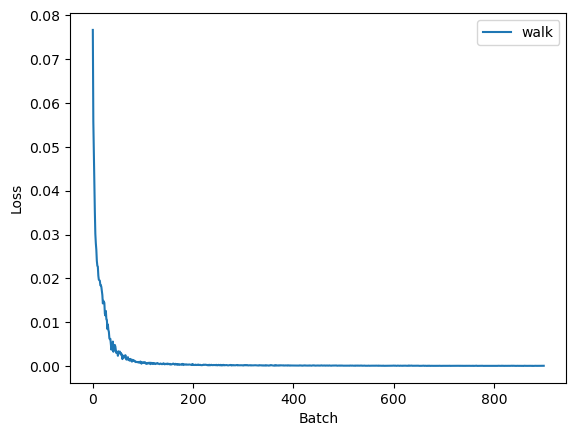

In [62]:
# Model hyperparameters
num_input = 29 # 24 angles, 4 touch sensors, 1 sinusoid
num_output = 24 # 24 angles for next time step
# layer_sizes = [33, 31, 30, 28]
layer_sizes = [num_input, 32, 32, num_output]

# Training hyperparameters
num_epochs = 100
batch_size = 32
learning_rate = 0.01

for gait_name in datasets:

    dataset = datasets[gait_name]

    print(f"Processing the '{gait_name}' dataset.")

    model, losses = train(
        dataset,
        num_epochs,
        batch_size,
        learning_rate,
        layer_sizes,
        batch_norm=False,
        dropout=0,
    )

    predictions = inference(model, dataset)

    # Save the outputs to a csv for quicker comparisons later
    with open(DATA_DIR / f"{gait_name}_model.csv", "w") as csvfile:

        writer = csv.writer(csvfile)

        writer.writerow(csv_header)

        for row in predictions:
            writer.writerow(row.tolist())

    torch.save(model, MODEL_DIR / f"{gait_name}_model.pt")

    final_loss = sum(losses[-100:]) / 100

    print(f"Final loss for {gait_name}: {final_loss}")

    plt.plot(losses, label=gait_name)

plt.xlabel("Batch")
plt.ylabel("Loss")
plt.legend()

plt.savefig(FIGURE_DIR / f"losses.png", facecolor="white")

## Sanity Check Data By Plotting

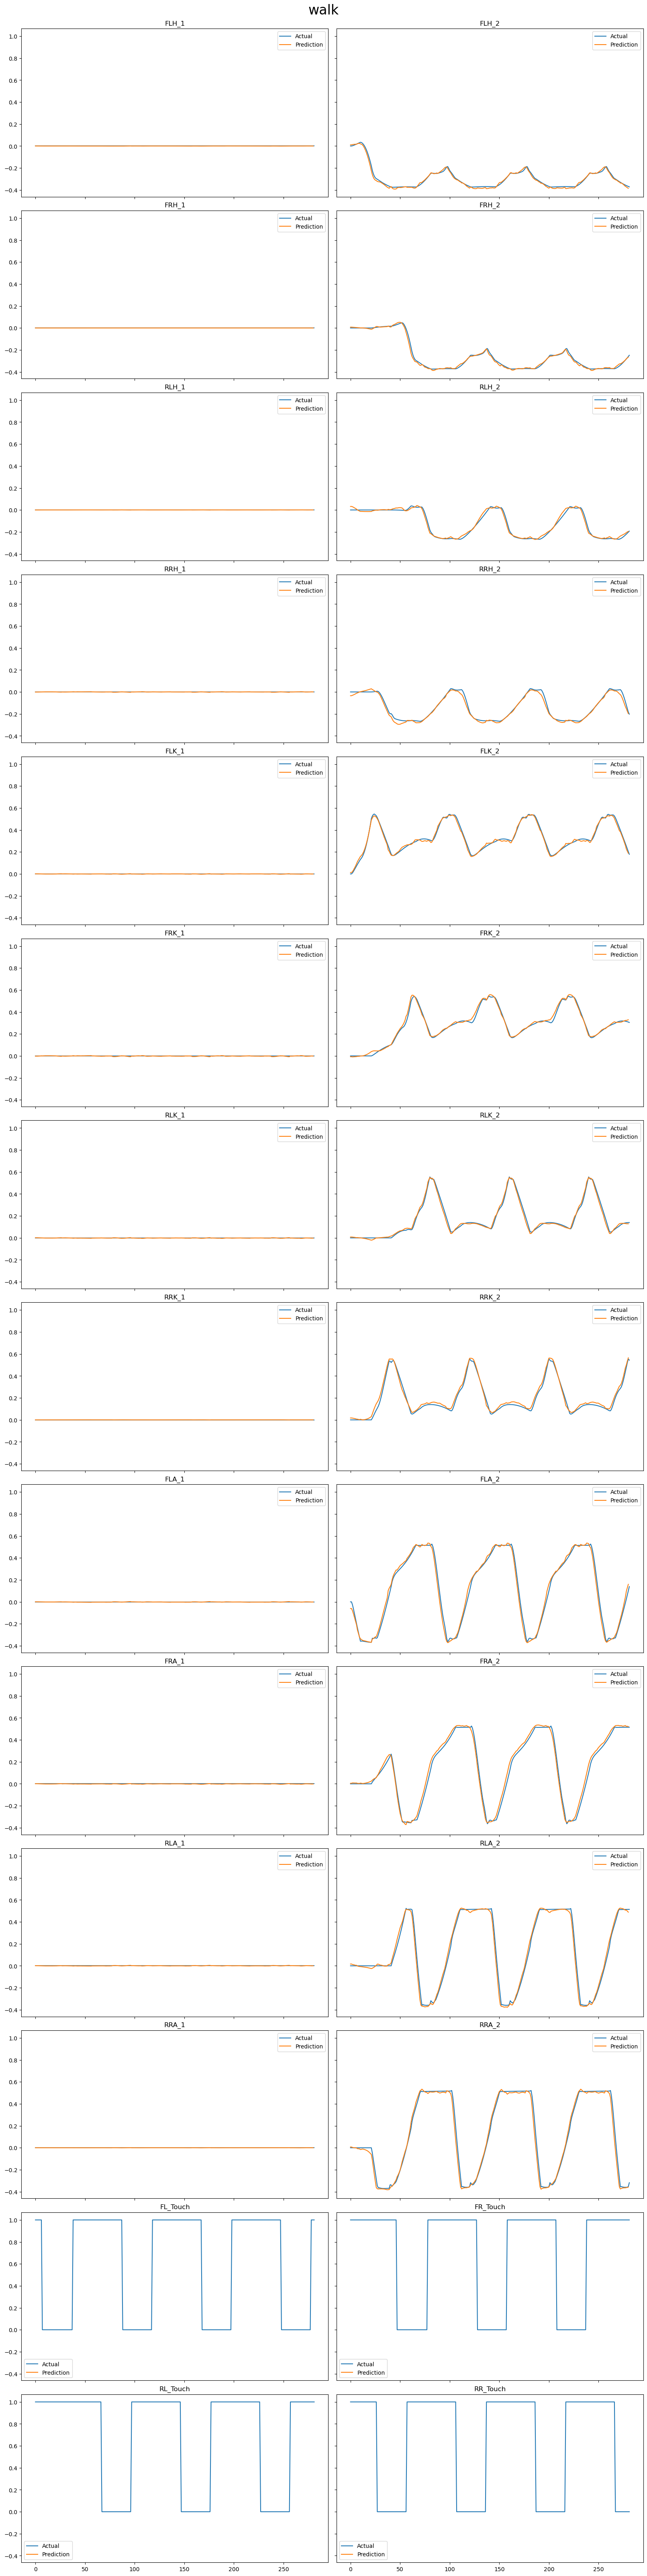

In [63]:

kinematics = sorted([f for f in DATA_DIR.glob("*_kinematic.csv") if f.is_file()])
outputs = sorted([f for f in DATA_DIR.glob("*_model.csv") if f.is_file()])

for actual, pred in zip(kinematics, outputs):

    dfa = pd.read_csv(actual)
    dfp = pd.read_csv(pred)

    columns = dfp.columns
    num_cols = len(columns)

    fig, axes = plt.subplots(
        num_cols // 2,
        2,
        figsize=(16, 64),
        sharex=True,
        sharey=True,
        constrained_layout=True,
    )

    gait_name = actual.stem.split("_")[0]

    fig.suptitle(gait_name, fontsize=24)

    for col, ax in zip(columns, axes.flatten()):
        ax.plot(dfa[col], label="Actual")
        ax.plot(dfp[col], label="Prediction")
        ax.set_title(col)
        ax.legend()

    fig.savefig(FIGURE_DIR / f"{gait_name}_comparison.png", facecolor="white")

In [55]:
!jupytext --sync gait_training.ipynb

[jupytext] Reading gait_training.ipynb in format ipynb
[jupytext] Updating gait_training.py
